<a href="https://colab.research.google.com/github/nianlonggu/Tensorflow-Notebooks/blob/master/Training_a_Wasserstein_GAN_on_the_free_google_colab_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Why using TPU?<br>
TPU is much faster than GPU. A single TPU contains 8 cores, each with a 8GB memory. During training, each batch of data is equally dispatched to all 8 cores. This means the equivalent memrory size if 8x8 = 64 GB. This make it possible to train some large models.

2. How to run GAN on TPU? <br>
Using TPU Estimator.<br>
Different from classic classification task, training of GAN involves alternation between training Generator and Discriminator. This fact makes it imossible to simply use Keras on TPU. TPU Estimator allows you to more flexibiy configure the network and training optimizer behaviors

#Start of coding

In [0]:
# here we force google colab to use tensorflow 1.x, the configuration will be slightly different for tf 2.0
%tensorflow_version 1.x
import tensorflow as tf
# tf.enable_eager_execution()
import numpy as np
# we use mnist dataset as an example
import keras.datasets.mnist as mnist
import math
import os
import matplotlib.pyplot as plt
import imageio
# This is needed for access the google cloud storage to save/restore the model and load the training/testing data.
from google.colab import auth
auth.authenticate_user()

## Step 0: Some helper function for visualizing the results

In [0]:
def add_padding( x, padding_size=(2,2,2,2), padding_value = 1 ):
    # x is a 4 d ndarray with range [0,1]
    background = padding_value * np.ones(  [ x.shape[0], x.shape[1]+ padding_size[0]+padding_size[2], x.shape[2] + padding_size[1]+padding_size[3], x.shape[3]   ]  ).astype(np.float32)
    background[:, padding_size[0]:-padding_size[2], padding_size[1]:-padding_size[3], : ] = x
    padded_x = background
    return padded_x

# to convert a bulk of images into grid of images
def make_grid(images,  ncol= None):
	# ncol represents the number of columns of the image grid, if ncol is None, then arrange the grid as close to a square as possible
	# This function always assume that the input image is RGB color space , normalized float type
	if np.max(images)-np.min(images) >1 :
		images = np.clip( images, -1,1 )
		images = images /2 +0.5
		
	image_num = images.shape[0]
	num_h = None
	num_w = None
	im_h = images.shape[1]
	im_w = images.shape[2]   
	im_c = images.shape[3]
	if (ncol==None):
		num_w = int( np.ceil(np.sqrt(image_num )))
		num_h = int( np.ceil( image_num/ num_w ))
	else:
		num_w = int(ncol)
		num_h = int( np.ceil(  image_num/num_w ))

	# create a white pannel, which is a [height, width, channel] ndarray
	pannel = np.ones(( num_h * im_h, num_w * im_w , im_c )).astype(np.float32)

	for i in range( image_num ):
		start_h = int(i / num_w) * im_h
		start_w = (i % num_w) * im_w
		pannel[ start_h: start_h+im_h , start_w : start_w + im_w ,: ]= images[i,:,:,:]
	return  pannel

## Step 1: preparation of training dataset

For using TPU in a practical scenario, it is recommended to use **tf.data.TFRecordDataset**. The reason of not using **tf.data.Dataset.from_tensor_slices** is this will store the training dataset directly to the computation graph, which will consume a lot of memory, especially for large training dataset.

A typical work flow is: 
1. generating TFRecod locally; 
2. uploading TFRecord to google cloud storage bucket; 
3. load TFRecord data using TFRecordDataset during training.

Get the original image data, write them into TFRecord file. Each image is corresponding to a single record in the TFRecord file

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train= X_train[:,:,:,np.newaxis]
X_test = X_test[ :,:,:,np.newaxis ]
X_train = (X_train/255).astype(np.float32)
X_test = (X_test/255).astype(np.float32)

print(X_train.shape)

The image shape will be used later on. Then we write mnist images into TFRecord files.

In [0]:
def make_tfrecord( file_name, images ):
    # define a TFRecordWriter
    writer = tf.python_io.TFRecordWriter(file_name, options= tf.io.TFRecordOptions(tf.io.TFRecordCompressionType.GZIP) )
    for img in images:
        if isinstance( img, str ):  # This case img is the path to the image file
            img =imageio.imread(img)
            img = (img/255.0).astype(np.float32)
        features = { 
            "image": tf.train.Feature( float_list = tf.train.FloatList( value = img.reshape(-1) ) ),
            "image_shape": tf.train.Feature( int64_list = tf.train.Int64List( value = img.shape )  )}
        # tf_serialized_example contains the serialized information about the value and shape of an image
        tf_serialized_example = tf.train.Example( features = tf.train.Features( feature = features ) ).SerializeToString()
        writer.write( tf_serialized_example )
    writer.close()

In [0]:
make_tfrecord( 'mnist_train.tfrecord', X_train  )
make_tfrecord( 'mnist_eval.tfrecord', X_test[:5000] )

Copy the generated TFRecord to the GCS storage bucket.



In [0]:
! gsutil cp mnist_train.tfrecord mnist_eval.tfrecord gs://gan-tpu-tutorial/data

One can also load multiple TFRecords by 


```
ds=tf.data.TFRecordDataset(["record1.tfrecord","record2.tfrecord","record3.tfrecord"], compression_type='GZIP')
```



## Step 2: configure the TPU Estimator

The TPU Estimator mainly contains two parts: train/eval/test input function, and model function

### Prepeare the input_functions for tf estimator

In [0]:
 def parse_tfrecord_func( serialized_record ):
    parse_dic = { "image": tf.FixedLenFeature(shape=(28,28,1), dtype = tf.float32 ),
                  "image_shape": tf.FixedLenFeature( shape=(3,), dtype = tf.int64 ) 
                }
    parses_record = tf.parse_single_example( serialized_record, parse_dic )
    ## note that parse_single_example can only be placed before batch()
    ## parse_example can only be placed after batch()
    return {"image": parses_record["image"]}
 
def train_input_fn( batch_size ):
    
    dataset_x_train = tf.data.TFRecordDataset([ "gs://gan-tpu-tutorial/data/mnist_train.tfrecord" ], compression_type='GZIP')
    
    dataset_x_train = dataset_x_train.shuffle(60000).repeat()
    pattern = np.array([0,0,0,0,1]).repeat(batch_size).astype(np.float32)
    dataset_g_w = tf.data.Dataset.from_tensor_slices( { "g_w": pattern  } ).repeat()
    dataset_output = tf.data.Dataset.from_tensor_slices( ( np.zeros( ( batch_size ) ).astype(np.float32) ) ).repeat()
    
    ds = tf.data.Dataset.zip(( dataset_x_train, dataset_g_w, dataset_output))
    def merge_func(a,b,c):
        a = parse_tfrecord_func(a)
        a.update(b)
        return a, c
    ds = ds.map(merge_func)
    return ds.batch( batch_size, drop_remainder = True ).prefetch(buffer_size =1)

def eval_input_fn( batch_size ):
    dataset_x_eval = tf.data.TFRecordDataset([ "gs://gan-tpu-tutorial/data/mnist_eval.tfrecord" ], compression_type='GZIP')
    dataset_x_eval = dataset_x_eval.shuffle(10000).repeat()
    dataset_output = tf.data.Dataset.from_tensor_slices( ( np.zeros( ( batch_size ) ).astype(np.float32) ) ).repeat()
    
    ds = tf.data.Dataset.zip(( dataset_x_eval, dataset_output))
    def merge_func(a,b):
        a = parse_tfrecord_func(a)
        return a, b
    ds = ds.map(merge_func)
    return ds.batch(batch_size, drop_remainder = True).prefetch(buffer_size =1)

def predict_input_fn( z ):
    dataset_z_input = tf.data.Dataset.from_tensor_slices( ( z.astype(np.float32), np.zeros(( z.shape[0],) ).astype(np.float32)  ) )
    return dataset_z_input.batch(64, drop_remainder= False)


1. dataset_x_train is loaded from the TFRecordDataset, the parse_tfrecord_func is used to convert the serialized tf record examples into image tensors.
2. g_w is used to control when to update the generator's parameters. Here the pattern "0 0 0 0 1" means training the generator once for every n_critic = 5 batches as stated in WGAN-GP.  This setting is due to the special property of the TPU mechanism
3. dataset_output is some dummy values (0) for the label parameter of the estimator.train() function
4. Each batch of ds contains follows contents:
```
 features: {"image": image_tensors, "g_w": g_w }
 labels: dataset_output (dummy value 0)
```
5. predict_input_fn doesn't use TFRecord, since in GAN during test we would like to input some random latent vectors to get the output, therefore, using Dataset.from_tensor_slices is more flexible.


 

### Define the model_fn part of the TPUEstimator

#### To be more compact, we first design the generator and discriminator

In [0]:
def generator( z, scope="generator", trainable= True ):
    with tf.variable_scope( scope, reuse= tf.AUTO_REUSE ):
        net = tf.layers.BatchNormalization()( tf.layers.Dense( 7*7*128, activation= tf.nn.relu )(z) )
        net = tf.reshape( net, [ tf.shape(net)[0], 7, 7, 128 ] )
        net = tf.layers.BatchNormalization()( tf.layers.Conv2DTranspose( 64, 5, (2,2), "same", activation= tf.nn.relu )(net) )
        net = tf.layers.BatchNormalization()( tf.layers.Conv2DTranspose( 32, 5, (2,2), "same", activation= tf.nn.relu )(net) )
        net = tf.layers.Conv2D(1, 5, (1,1), "same", activation= tf.nn.sigmoid  )(net)
        return net

def discriminator( x, scope="discriminator", trainable = True ):
    with tf.variable_scope( scope, reuse= tf.AUTO_REUSE ):
        net = tf.layers.Conv2D( 32, 5, (2,2), "same", activation= tf.nn.leaky_relu )(x) 
        net = tf.layers.BatchNormalization()( tf.layers.Conv2D( 64, 5, (2,2), "same", activation= tf.nn.leaky_relu )(net) )
        net = tf.layers.BatchNormalization()( tf.layers.Conv2D( 128, 5, (2,2), "same", activation= tf.nn.leaky_relu )(net) )
        net = tf.layers.Flatten()(net)
        net = tf.layers.BatchNormalization()( tf.layers.Dense( 128, activation= tf.nn.leaky_relu  )(net) )
        net = tf.layers.Dense( 1 )(net)
        return net

Define some metric functions for evaluation

In [0]:
def metric_fn(loss_gen, loss_dis, W_dis ):
    """Function to return metrics for evaluation.
    The input parameters can be arbritary
    """
    return {"loss_gen": tf.metrics.mean(loss_gen), 
            "loss_dis": tf.metrics.mean(loss_dis),
            "wasserstein_distance": tf.metrics.mean( W_dis ),
            }

In [0]:
def model_fn(features, labels, mode, params):
    
    lr = params["learning_rate"]
    z_dim = params["z_dim"]
    
    if mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL:
        """ Part I. create the model networks"""
        x = features["image"]
        is_train = mode == tf.estimator.ModeKeys.TRAIN
        random_z = tf.random.normal( [tf.shape(x)[0], z_dim ]  )
        gen_x = generator( random_z, trainable= is_train )
        dis_x = discriminator( x, trainable= is_train )
        dis_gen_x = discriminator( gen_x, trainable= is_train )

        # This is used to compute the gradient penalty
        epsilon = tf.random.uniform( [ tf.shape(x)[0],1,1,1 ], minval=0, maxval= 1 )
        interp_x = epsilon * x + (1-epsilon) * gen_x
        dis_interp_x = discriminator( interp_x, trainable= is_train )
        gradient_x = tf.gradients( dis_interp_x, [ interp_x ]  )[0]
        gradient_penalty = tf.square( tf.sqrt( tf.reduce_sum( tf.square(gradient_x ),[1,2,3] ) ) - 1  )
        LAMBDA = 10
    
        """Part II. define the loss and relative parameters for mode == TRAIN/EVAL/PREDICT"""
        ## compute loss
        loss_dis = dis_gen_x  - dis_x + LAMBDA * gradient_penalty 
        loss_gen = - dis_gen_x
        W_dis = dis_x - dis_gen_x

        ## operations for the training mode, define the optimizer, and reconfig it using tpu.CrossShardOptimizer
        if mode == tf.estimator.ModeKeys.TRAIN:
            g_w = features["g_w"]
            loss_dis = tf.reduce_mean( loss_dis   )  
            ## when g_w =0, this loss_gen 's gradient will be 0, which means generator is not trained during current batch
            loss_gen = tf.reduce_mean( loss_gen * g_w)
            W_dis = tf.reduce_mean(W_dis)

            # Define the optimizer
            d_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=0, beta2= 0.99 )
            g_optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=0, beta2= 0.99 )
            # convert to TPU optimizer version
            d_optimizer = tf.tpu.CrossShardOptimizer(d_optimizer)
            g_optimizer = tf.tpu.CrossShardOptimizer(g_optimizer)

            with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS )):
                d_op = d_optimizer.minimize( loss = loss_dis, var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,\
                                           scope="discriminator")  )
                g_op = g_optimizer.minimize(loss = loss_gen,  var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,\
                                           scope="generator"),global_step= tf.train.get_global_step() )
                # This group command will group the discriminator optimization and generator optimization together
                # all the optimizations in the group will be run during each batch
                # g_w can control whether to update the parameters of generator or not, which plays the role of n_critic in WGAN
                train_op = tf.group( [ d_op , g_op] )
                spec= tf.estimator.tpu.TPUEstimatorSpec(mode=mode, loss= W_dis ,train_op= train_op  )
    
        ## for EVAL mode, the parameters eval_metrics takes a tuple or list of two elements. The first element is a callable function,
        ## The second element is a list of parameters. The return value of the callable function will be shown in the evaluatio results
        elif mode == tf.estimator.ModeKeys.EVAL:
            spec = tf.estimator.tpu.TPUEstimatorSpec(mode=mode, loss= tf.reduce_mean(W_dis), eval_metrics=(metric_fn, [loss_gen, loss_dis, W_dis ] ) )
    
    elif mode == tf.estimator.ModeKeys.PREDICT:
        """ construct the model (only the generator part) """
        input_z = features
        gen_x = generator( input_z, trainable= False )

        """Define the predictions"""
        predictions = { "generated_images":  gen_x   }
        spec= tf.estimator.tpu.TPUEstimatorSpec( mode = mode, predictions = predictions )

    return spec


## Create the TPUEstimator entity, and run the train / evaluate/ predict

iterations_per_loop means the number of batches fed into TPU before returning to the host CPU

In [0]:
model_dir="gs://gan-tpu-tutorial/model"
tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
iterations_per_loop = 200

run_config = tf.estimator.tpu.RunConfig(
        model_dir=model_dir,
        cluster=tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address),
        session_config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True),
        tpu_config=tf.estimator.tpu.TPUConfig(iterations_per_loop),
        )

model = tf.estimator.tpu.TPUEstimator(
                               model_fn=model_fn,
                               params = {"learning_rate": 1e-3, "z_dim": 100 },
                               config = run_config,
                               use_tpu= True,
                               train_batch_size=512  ,
                               eval_batch_size=512 ,
                               predict_batch_size= 64,
                              ) 

### Training

What is the relationship between max_steps and epochs?



* max_epoch = max_steps * batch_size / total_number_of_training_samples




In [0]:
model.train( input_fn = lambda params: train_input_fn( params["batch_size"] ), max_steps= 15000 )

### Evaluate

In [0]:
eval_result = model.evaluate(input_fn=lambda params: eval_input_fn( params["batch_size"]), steps = 10)
eval_result

### Predict

In [0]:
random_z = np.random.normal( size=(1024, 100)  ).astype(np.float32)
pred_results = model.predict( input_fn=lambda params: predict_input_fn(random_z) )
images = np.array([ result["generated_images"] for result in pred_results  ])

generated images


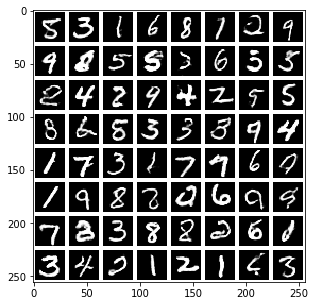

In [17]:
print("generated images")
plt.figure(figsize = (5,5)) 
plt.gray()
plt.imshow( make_grid(add_padding(images[np.random.choice( images.shape[0], 64, replace= False )  ])).squeeze() )
plt.show()

imageio.imsave( "random.png",  make_grid(add_padding(images)).squeeze() )